In [38]:
import boto3
import pandas as pd
import numpy as np
import io
import sys
import os
import time
import seaborn as sns
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# local libraries
#sys.path.append(os.path.abspath(os.path.join(sys.path[0], '..', 'src', 'lib')))
sys.path.append('/mnt/src/lib') # Domino
import market_maker_training

# options
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.mode.chained_assignment = None
%matplotlib inline

In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
coin_pair_dict = {'target':'btcusdt',
                  'alt':'ethusdt',
                  'through':'xrpusdt'}
feature_minutes_list = [1, 3, 5, 8, 11, 14, 18, 22, 30, 40, 50, 60, 120, 240, 480, 960, 2000]
feature_minutes_list = [5]
trade_window_list = [6]

In [56]:
def get_feature_data(coin_pair_dict, feature_minutes_list, trade_window_list):
    mm_training = market_maker_training.BinanceTraining(coin_pair_dict, feature_minutes_list, trade_window_list)
    try:
        mm_training.set_training_data()
    except Exception as e:
        print(f"Failed setting training data: {e}")
        return
    return mm_training.training_df, mm_training.feature_column_list, mm_training.target_column_list

In [57]:
features_df, feature_col, target_col_list = get_feature_data(coin_pair_dict, feature_minutes_list, trade_window_list)
features_df.tail(20)

(687672, 121)
(687667, 121)


,btcusdt_trade_datetime,btcusdt_trade_date,btcusdt_trade_minute,trade_day_of_week,trade_hour,days_old,btcusdt_bid_ask_spread,btcusdt_bid_ask_average_price,btcusdt_bids_cum_5000_weighted_avg,btcusdt_bids_cum_10000_weighted_avg,btcusdt_bids_cum_20000_weighted_avg,btcusdt_bids_cum_50000_weighted_avg,btcusdt_bids_cum_100000_weighted_avg,btcusdt_bids_cum_200000_weighted_avg,btcusdt_bids_cum_5000_weighted_std,btcusdt_bids_cum_10000_weighted_std,btcusdt_bids_cum_20000_weighted_std,btcusdt_bids_cum_50000_weighted_std,btcusdt_bids_cum_100000_weighted_std,btcusdt_bids_cum_200000_weighted_std,btcusdt_asks_cum_5000_weighted_avg,btcusdt_asks_cum_10000_weighted_avg,btcusdt_asks_cum_20000_weighted_avg,btcusdt_asks_cum_50000_weighted_avg,btcusdt_asks_cum_100000_weighted_avg,btcusdt_asks_cum_200000_weighted_avg,btcusdt_asks_cum_5000_weighted_std,btcusdt_asks_cum_10000_weighted_std,btcusdt_asks_cum_20000_weighted_std,btcusdt_asks_cum_50000_weighted_std,btcusdt_asks_cum_100000_weighted_std,btcusdt_asks_cum_200000_weighted_std,ethusdt_bid_ask_spread,ethusdt_bid_ask_average_price,ethusdt_bids_cum_5000_weighted_avg,ethusdt_bids_cum_10000_weighted_avg,ethusdt_bids_cum_20000_weighted_avg,ethusdt_bids_cum_50000_weighted_avg,ethusdt_bids_cum_100000_weighted_avg,ethusdt_bids_cum_200000_weighted_avg,ethusdt_bids_cum_5000_weighted_std,ethusdt_bids_cum_10000_weighted_std,ethusdt_bids_cum_20000_weighted_std,ethusdt_bids_cum_50000_weighted_std,ethusdt_bids_cum_100000_weighted_std,ethusdt_bids_cum_200000_weighted_std,ethusdt_asks_cum_5000_weighted_avg,ethusdt_asks_cum_10000_weighted_avg,ethusdt_asks_cum_20000_weighted_avg,ethusdt_asks_cum_50000_weighted_avg,ethusdt_asks_cum_100000_weighted_avg,ethusdt_asks_cum_200000_weighted_avg,ethusdt_asks_cum_5000_weighted_std,ethusdt_asks_cum_10000_weighted_std,ethusdt_asks_cum_20000_weighted_std,ethusdt_asks_cum_50000_weighted_std,ethusdt_asks_cum_100000_weighted_std,ethusdt_asks_cum_200000_weighted_std,xrpusdt_bid_ask_spread,xrpusdt_bid_ask_average_price,xrpusdt_bids_cum_5000_weighted_avg,xrpusdt_bids_cum_10000_weighted_avg,xrpusdt_bids_cum_20000_weighted_avg,xrpusdt_bids_cum_50000_weighted_avg,xrpusdt_bids_cum_100000_weighted_avg,xrpusdt_bids_cum_200000_weighted_avg,xrpusdt_bids_cum_5000_weighted_std,xrpusdt_bids_cum_10000_weighted_std,xrpusdt_bids_cum_20000_weighted_std,xrpusdt_bids_cum_50000_weighted_std,xrpusdt_bids_cum_100000_weighted_std,xrpusdt_bids_cum_200000_weighted_std,xrpusdt_asks_cum_5000_weighted_avg,xrpusdt_asks_cum_10000_weighted_avg,xrpusdt_asks_cum_20000_weighted_avg,xrpusdt_asks_cum_50000_weighted_avg,xrpusdt_asks_cum_100000_weighted_avg,xrpusdt_asks_cum_200000_weighted_avg,xrpusdt_asks_cum_5000_weighted_std,xrpusdt_asks_cum_10000_weighted_std,xrpusdt_asks_cum_20000_weighted_std,xrpusdt_asks_cum_50000_weighted_std,xrpusdt_asks_cum_100000_weighted_std,xrpusdt_asks_cum_200000_weighted_std,avg_5_ethusdt_bid_ask_average_price_interaction,avg_10_ethusdt_bid_ask_average_price_interaction,avg_20_ethusdt_bid_ask_average_price_interaction,prev_5_btcusdt_bid_ask_average_price_perc_chg,prev_5_btcusdt_bid_ask_average_price_rate_chg,prev_5_btcusdt_bids_cum_5000_weighted_avg_perc_chg,prev_5_btcusdt_bids_cum_50000_weighted_avg_perc_chg,prev_5_btcusdt_bids_cum_100000_weighted_avg_perc_chg,prev_5_btcusdt_bids_cum_200000_weighted_avg_perc_chg,prev_5_btcusdt_asks_cum_5000_weighted_avg_perc_chg,prev_5_btcusdt_asks_cum_50000_weighted_avg_perc_chg,prev_5_btcusdt_asks_cum_100000_weighted_avg_perc_chg,prev_5_btcusdt_asks_cum_200000_weighted_avg_perc_chg,prev_btcusdt_5_askbid_cum_5000_weighted_avg_perc_chg,prev_5_ethusdt_bid_ask_average_price_perc_chg,prev_5_ethusdt_bid_ask_average_price_rate_chg,prev_5_ethusdt_bids_cum_5000_weighted_avg_perc_chg,prev_5_ethusdt_bids_cum_50000_weighted_avg_perc_chg,prev_5_ethusdt_bids_cum_100000_weighted_avg_perc_chg,prev_5_ethusdt_bids_cum_200000_weighted_avg_perc_chg,prev_5_ethusdt_asks_cum_5000_weighted_avg_perc_chg,prev_5_ethusdt_asks_cum_50000_weighted_avg_perc_chg,prev_5_ethusdt_asks_cu

### Feature Correlations with Outcome 

In [58]:
# add target to list of columns
feature_col_extended = feature_col[:]
feature_col_extended.append(target_col_list[0])
# calculate correlations
corr_df = features_df[feature_col_extended]
corr_col = corr_df.corr()[[target_col_list[0]]]
# order 
corr_col.columns = ['corrs']
corr_col['corrs_abs'] = corr_col['corrs'].abs()

In [59]:
corr_col.sort_values('corrs_abs', ascending=False)

,corrs,corrs_abs
futr_6_askbid_cum_5000_weighted_avg_perc_chg,1.000000,1.000000
avg_5_ethusdt_bid_ask_average_price_interaction,0.227299,0.227299
avg_10_ethusdt_bid_ask_average_price_interaction,0.195655,0.195655
avg_20_ethusdt_bid_ask_average_price_interaction,0.166381,0.166381
prev_5_ethusdt_bids_cum_5000_weighted_avg_perc_chg,0.113940,0.113940
prev_5_ethusdt_asks_cum_5000_weighted_avg_perc_chg,0.113886,0.113886
prev_5_ethusdt_bid_ask_average_price_perc_chg,0.113788,0.113788
prev_5_ethusdt_bids_cum_50000_weighted_avg_perc_chg,0.106776,0.106776
prev_5_ethusdt_asks_cum_50000_weighted_avg_perc_chg,0.106630,0.106630
prev_5_ethusdt_asks_cum_100000_weighted_avg_perc_chg,0.101772,0.101772


## Model Based Feature Importances

In [60]:
target_col = target_col_list[0]
# Remove recent rows with no observable future state
features_df = features_df[:-15]
# Split to retain 1 week for scoring and adjust for previous periods with no observable values for lagged features
#X_train, y_train = features_df[960:-7225][feature_col], features_df[960:-7225][target_col]  
#X_test, y_test = features_df[-7200:][feature_col], features_df[-7200:][target_col]
X_train, y_train = features_df[200000:-7225][feature_col], features_df[200000:-7225][target_col]  # fewer days of training data
X_test, y_test = features_df[-7200:][feature_col], features_df[-7200:][target_col]

In [ ]:
def print_metrics(model, y_test, X_test):
    r2 = r2_score(y_test, model.predict(X_test))
    neg_mse = mean_squared_error(y_test, model.predict(X_test))
    print(f"R2: {r2}, neg_mean_squared_error: -{neg_mse}")
    return r2

### Random Forest 

In [ ]:
# Finding params that won't overfit...
def train_test_rf(params):
    rf = ensemble.RandomForestRegressor(n_estimators=500, max_depth=params['max_depth'], 
                                        max_features=params['max_features'], 
                                        min_samples_leaf=params['min_samples_leaf'],
                                        min_samples_split=params['min_samples_split'])
    rf.fit(X_train, y_train)
    print("Overfitting? Train fit:")
    print_metrics(rf, y_train, X_train)
    print("Test fit:")
    r2 = print_metrics(rf, y_test, X_test)
    return r2

rf_param_grid = {'max_depth': [10],
                 'max_features': ['sqrt'],
                 'min_samples_leaf': [2],
                 'min_samples_split': [5]}
pgrid = ParameterGrid(rf_param_grid)

print(len(list(pgrid)))

best_test_score=0
best_params={}

for params in pgrid:
    print(time.time())
    print(params)
    test_r2 = train_test_rf(params)
    if test_r2 > best_test_score:
        best_test_score = test_r2
        best_params = params
print(f"Best score = {best_test_score}")
print(f"Best params = {best_params}")

In [ ]:
rf = ensemble.RandomForestRegressor(n_estimators=50, max_depth=10, max_features=.50, min_samples_leaf=2)
rf.fit(X_train, y_train)
print("Overfitting? Train fit:")
print_metrics(rf, y_train, X_train)
print("Test fit:")
print_metrics(rf, y_test, X_test)

In [ ]:
for name, importance in zip(X_train.columns, rf.feature_importances_):
    print(name, ": ", importance)

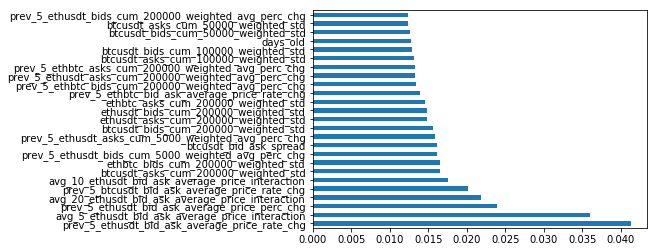

In [12]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh')

### Feature Weights (SGD Regressor)

In [ ]:
# transform and scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

sgd = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='elasticnet', alpha=0.005, max_iter=2000)
sgd.fit(X_train_std, y_train)
print("Overfitting? Train fit:")
print_metrics(sgd, y_train, X_train_std)
print("Test fit:")
print_metrics(sgd, y_test, X_test_std)

Overfitting? Train fit:
R2: 0.07731770208403621, neg_mean_squared_error: -0.0537131444120625
Test fit:
R2: -0.06408872420345624, neg_mean_squared_error: -0.022280534058282914


-0.06408872420345624

In [ ]:
list(zip(sgd.coef_, feature_col))

[(0.0, 'trade_day_of_week'),
 (0.005095479360992376, 'trade_hour'),
 (0.0050532243781343114, 'days_old'),
 (-0.01310190799330277, 'btcusdt_bid_ask_spread'),
 (0.0, 'btcusdt_bid_ask_average_price'),
 (0.0, 'btcusdt_bids_cum_5000_weighted_avg'),
 (0.0, 'btcusdt_bids_cum_10000_weighted_avg'),
 (0.0, 'btcusdt_bids_cum_20000_weighted_avg'),
 (0.0, 'btcusdt_bids_cum_50000_weighted_avg'),
 (0.0, 'btcusdt_bids_cum_100000_weighted_avg'),
 (0.0, 'btcusdt_bids_cum_200000_weighted_avg'),
 (0.0, 'btcusdt_bids_cum_5000_weighted_std'),
 (0.0, 'btcusdt_bids_cum_10000_weighted_std'),
 (0.0, 'btcusdt_bids_cum_20000_weighted_std'),
 (0.0, 'btcusdt_bids_cum_50000_weighted_std'),
 (0.0, 'btcusdt_bids_cum_100000_weighted_std'),
 (-0.00283186712218891, 'btcusdt_bids_cum_200000_weighted_std'),
 (0.0, 'btcusdt_asks_cum_5000_weighted_avg'),
 (0.0, 'btcusdt_asks_cum_10000_weighted_avg'),
 (0.0, 'btcusdt_asks_cum_20000_weighted_avg'),
 (0.0, 'btcusdt_asks_cum_50000_weighted_avg'),
 (0.0, 'btcusdt_asks_cum_100000_